In [2]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask

set_plotting_style()

try:
    from yahist import Hist1D, Hist2D
except:
    !pip install git+git://github.com/aminnj/yahist.git#egg=yahist -U
    from yahist import Hist1D, Hist2D

In [157]:
def make_df(fname):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["n*","pass_*",
                     "MET_*",
                     "/BS_(x|y|z)$/",
                     "/Jet_(pt|eta|phi|m)$/",
                     "/Muon_(pt|eta|phi|m|n.*|trackIso|charge|trk_qoverp.*|dxy.*|chi2|ndof|vx|vy|vz|jetIdx.*)$/",
                     "/DV_(tracksSize|chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError)$/",
                     "run","luminosityBlock","event",
                    ],outputtype=dict,namedecode="ascii")
    
    # booleans for selection
    sel = (
        (arrs["nDV"] == 1) 
        & (arrs["nMuon"] == 2) 
        & arrs["pass_l1"] 
        & arrs["pass_skim"] 
        & arrs["pass_fiducialgen"]
        & (arrs["DV_rho"]>1.0).any()
    )

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi","event"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]
        if k.startswith("Jet_"):
            # make sure there is at least 1 jet per event, filled with 0s
            padded = arrs[k][sel].pad(1).fillna(0.)
            # convert index of -1 (no jet found) to at least 0, and then we will pick up the 
            # dummy 0s from the padded array
            vals = padded[np.maximum(arrs["Muon_jetIdx1"][sel],0)]
            df[k.replace("Jet_","Muon1_Jet_")] = vals[:,0]
            df[k.replace("Jet_","Muon2_Jet_")] = vals[:,1]

    # augment
    TLVA = uproot_methods.TLorentzVectorArray
    TV2A = uproot_methods.TVector2Array
    mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],0.10566)
    mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],0.10566)
    jetmu1 = TLVA.from_ptetaphim(df["Muon1_Jet_pt"],df["Muon1_Jet_eta"],df["Muon1_Jet_phi"],df["Muon1_Jet_m"])
    jetmu2 = TLVA.from_ptetaphim(df["Muon2_Jet_pt"],df["Muon2_Jet_eta"],df["Muon2_Jet_phi"],df["Muon2_Jet_m"])
    dimu = mu1+mu2
    df["dimuon_mass"] = dimu.mass
    df["dimuon_eta"] = dimu.eta
    df["dimuon_phi"] = dimu.phi
    df["dimuon_pt"] = dimu.pt
    vecdimu = TV2A.from_polar(dimu.pt,dimu.phi)
    vecdv = TV2A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"])
    df["absdphimudv"] = np.abs(vecdimu.delta_phi(vecdv))
    df["absdphimumu"] = np.abs(mu1.delta_phi(mu2))
    df["cosphi"] = vecdimu.cosdelta(vecdv)
    df["angle3dmumu"] = np.arccos(mu1.p3.dot(mu2.p3)/(mu1.p3.mag*mu2.p3.mag))
    df["DV_redchi2"] = df["DV_chi2"]/df["DV_ndof"]
    df["DV_xyErrorMax"] = np.maximum(df["DV_xError"],df["DV_yError"])
    df["Muon1_redchi2"] = df["Muon1_chi2"]/df["Muon1_ndof"]
    df["Muon2_redchi2"] = df["Muon2_chi2"]/df["Muon2_ndof"]
    df["Muon1_adqpt"] = np.abs(df["Muon1_trk_qoverpError"]/df["Muon1_trk_qoverp"])
    df["Muon2_adqpt"] = np.abs(df["Muon2_trk_qoverpError"]/df["Muon2_trk_qoverp"])
    df["Muon1_m"] = 0.10566
    df["Muon2_m"] = 0.10566
    
    drs = mu1.delta_r(jetmu1)
    drs[jetmu1.pt<1] = 0.
    df["Muon1_drjet"] = drs
    df["Muon1_ptratio"] = (df["Muon1_pt"]/df["Muon1_Jet_pt"]).replace(np.inf,0.).fillna(0.)
    drs = mu2.delta_r(jetmu2)
    drs[jetmu2.pt<1] = 0.
    df["Muon2_drjet"] = drs
    df["Muon2_ptratio"] = (df["Muon2_pt"]/df["Muon2_Jet_pt"]).replace(np.inf,0.).fillna(0.)
    
    df["maxabsdxy"] = np.maximum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["minabsdxy"] = np.minimum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["maxdxy"] = np.maximum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    df["mindxy"] = np.minimum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    
    # skim more
    df = df.query(
        "(cosphi > 0.)"
        " and (Muon1_charge != Muon2_charge)"
        " and (DV_xyErrorMax < 0.05)"
        " and (DV_zError < 0.1)"
        " and (Muon1_nValidMuonHits > 0)"
        " and (Muon2_nValidMuonHits > 0)"
        " and (Muon1_redchi2 < 3)"
        " and (Muon2_redchi2 < 3)"
    )
    return df
#     return arrs
    
df_data = pd.concat(
    map(make_df,glob.glob(
        "/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_v6skim1cmjets/*.root"
    )[:1])
).reset_index(drop=True)
df_mc = make_df("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v6//output_1.root").reset_index(drop=True)

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in arccos


In [171]:
# uproot_methods.TLorentzVector.from_ptetaphim(15.732, -0.2243, 0.13507, 0.10566).delta_r(
#     uproot_methods.TLorentzVector.from_ptetaphim(0,0,0,0)
# )

df_data["Muon1_nExpectedPixelHits"]-df_data["Muon1_nValidPixelHits"]

0        0
1        1
2        3
3        0
4        0
        ..
25291    2
25292    1
25293    0
25294    1
25295    0
Length: 25296, dtype: int32

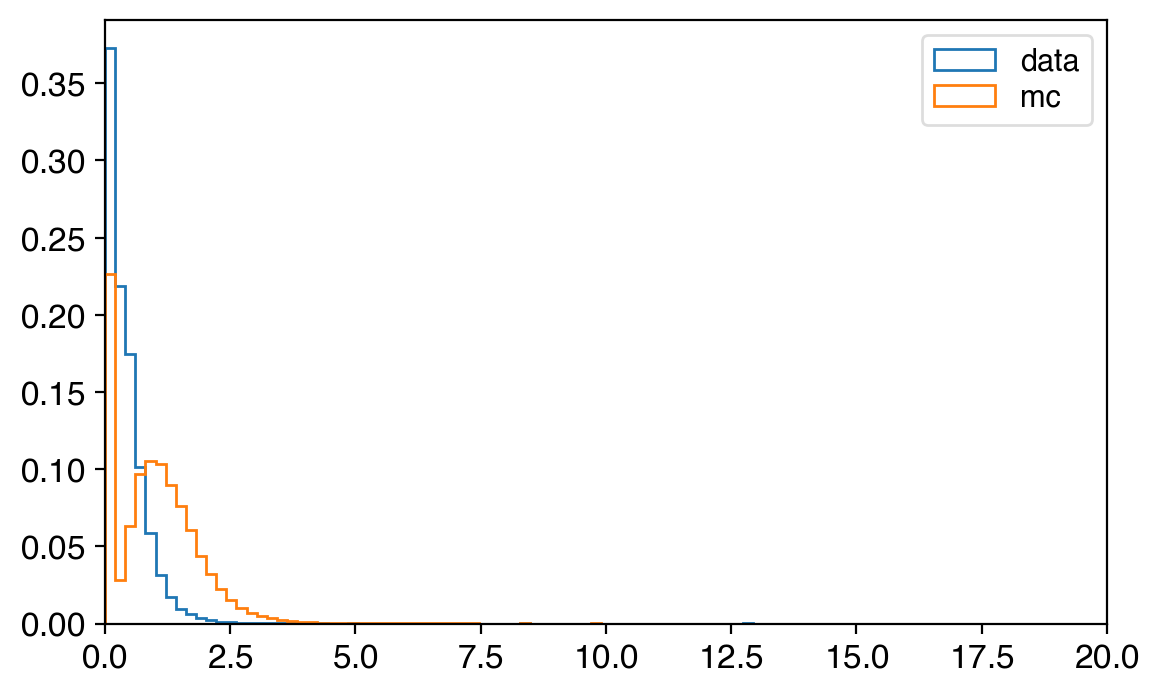

In [163]:
# df_data.filter(like="Muon1_Jet")
# Hist1D(df_data[df_data["Muon1_Jet_pt"]>0].eval("Muon1_pt / Muon1_Jet_pt"),bins=np.linspace(0,3,100))
# Hist1D(df_data[df_data["Muon2_Jet_pt"]>0].eval("Muon2_pt / Muon2_Jet_pt"),bins=np.linspace(0,3,100))
# Hist1D(df_data["Muon1_ptratio"],bins=np.linspace(0,3,100))
fig, ax = plt.subplots()
# v = "Muon1_drjet"
# v = "Muon1_Jet_pt"
# v = "Muon1_ptratio"
bins = np.linspace(0,20,100)
# bins = np.linspace(0,100,100)
Hist1D(df_data[v],bins=bins).normalize().plot(ax=ax,histtype="step",label="data")
Hist1D(df_mc[v],bins=bins).normalize().plot(ax=ax,histtype="step",label="mc")
ax.legend()



In [169]:
df_data.filter(like="Muon1_Jet")

,Muon1_Jet_pt,Muon1_Jet_eta,Muon1_Jet_phi,Muon1_Jet_m
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,88.433075,-0.453421,-0.475038,17.885456
4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
25291,28.192810,0.396673,1.404980,5.686672
25292,50.330524,-0.487040,-2.842260,9.440977
25293,0.000000,0.000000,0.000000,0.000000
25294,23.319729,0.991108,-0.542461,4.237841


In [44]:
Hist1D(df_data["nJet"],bins=np.arange(10)-0.5)

bin,content
"(-0.5,0.5)",7940 ± 89.1067
"(0.5,1.5)",7334 ± 85.6388
"(1.5,2.5)",6127 ± 78.2752
"(2.5,3.5)",2466 ± 49.6588
"(3.5,4.5)",877 ± 29.6142
"(4.5,5.5)",330 ± 18.1659
"(5.5,6.5)",127 ± 11.2694
"(6.5,7.5)",42 ± 6.48074
"(7.5,8.5)",53 ± 7.28011


In [45]:
# arrs["Muon_jetIdx1"]

In [46]:
df_data["Muon1_Jet_pt"] = 0.
df_data.loc[(df_data["Muon1_jetIdx1"]>0), "Muon1_Jet_pt"] = 2.0

In [47]:
df_data["Muon1_Jet_pt"]

0        0.0
1        0.0
2        0.0
3        2.0
4        0.0
        ... 
25291    0.0
25292    0.0
25293    0.0
25294    0.0
25295    0.0
Name: Muon1_Jet_pt, Length: 25296, dtype: float64

In [69]:
# mu1hasjet = arrs["Muon_jetIdx1"] >= 0
# arrs["Muon_jetIdx1"][mu1hasjet]
# arrs["Jet_pt"][mu1hasjet.any()][arrs["Muon_jetIdx1"]]

arrs["Jet_pt"].pad(2).fillna(0.)

<JaggedArray [[55.50544 48.529564 46.51123 34.783592 34.66653] [0.0 0.0] [33.704258 31.951544 30.358225 ... 21.12722 20.855068 20.33385] ... [0.0 0.0] [26.586372 23.461111 21.712978] [28.969313 0.0]] at 0x7fbf8ac774e0>

In [73]:
np.maximum(arrs["Muon_jetIdx1"],0)

<JaggedArray [[1 1] [0 0] [9 6] ... [0 0] [0 0] [0 0]] at 0x7fbf8ab5cc50>

In [76]:
arrs["Jet_pt"].pad(1).fillna(0.)[
    np.maximum(arrs["Muon_jetIdx1"],0)
]

<JaggedArray [[48.529564 48.529564] [0.0 0.0] [21.12722 23.646679] ... [0.0 0.0] [26.586372 26.586372] [28.969313 28.969313]] at 0x7fbf8639d278>

In [78]:
# "Muon1_Jet_pt"
arrs["Jet_pt"].pad(1).fillna(0.)[np.maximum(arrs["Muon_jetIdx1"],0)][:,0]

array([48.529564,  0.      , 21.12722 , ...,  0.      , 26.586372,
       28.969313], dtype=float32)